In [1]:
BATCH_SIZE = 32
MAX_LEN = 716
EMBEDDING_DIM = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [6]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [7]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN])
    
    return X, Y

In [8]:
%%time

x_train, y_train = iterator('train_with_sp.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test_with_sp.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 1.63 s, sys: 444 ms, total: 2.08 s
Wall time: 1.08 s


In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 716), (5893, 9), (1474, 716), (1474, 9))

In [11]:
hidden_dims = 128
epochs = 5

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Flatten

model = Sequential()
model.add(Embedding(8001, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Flatten())
model.add(Dense(hidden_dims, 
                activation='relu',
               ))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 716, 300)          2400300   
_________________________________________________________________
flatten_6 (Flatten)          (None, 214800)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               27494528  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 1161      
Total params: 29,895,989
Trainable params: 29,895,989
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [33]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 3s 518us/step - loss: 0.8493 - acc: 0.7153 - val_loss: 0.3132 - val_acc: 0.9050
Epoch 2/5
5893/5893 [==============================] - 2s 334us/step - loss: 0.0191 - acc: 0.9956 - val_loss: 0.2406 - val_acc: 0.9199
Epoch 3/5
5893/5893 [==============================] - 2s 332us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.2506 - val_acc: 0.9220
Epoch 4/5
5893/5893 [==============================] - 2s 333us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2476 - val_acc: 0.9227
Epoch 5/5
5893/5893 [==============================] - 2s 333us/step - loss: 6.3303e-04 - acc: 1.0000 - val_loss: 0.2520 - val_acc: 0.9220
CPU times: user 11.5 s, sys: 6.2 s, total: 17.7 s
Wall time: 11.6 s


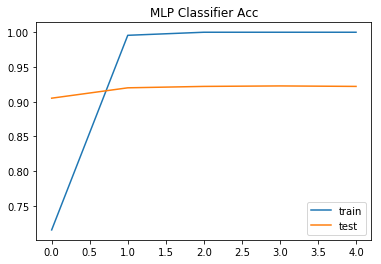

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('MLP Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

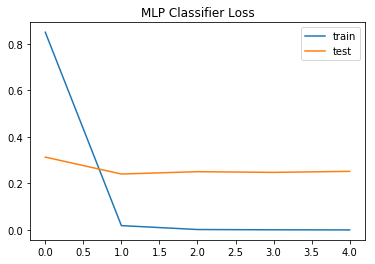

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('MLP Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [36]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.862     0.926     0.893       175
  it-life-hack      0.911     0.929     0.920       154
 kaden-channel      0.931     0.970     0.950       167
livedoor-homme      0.886     0.684     0.772       114
   movie-enter      0.945     0.983     0.963       174
        peachy      0.893     0.864     0.878       184
          smax      0.974     0.995     0.984       186
  sports-watch      0.974     0.914     0.943       163
    topic-news      0.909     0.955     0.932       157

     micro avg      0.922     0.922     0.922      1474
     macro avg      0.921     0.913     0.915      1474
  weighted avg      0.922     0.922     0.920      1474



Normalized confusion matrix
[[0.926 0.006 0.    0.023 0.023 0.023 0.    0.    0.   ]
 [0.006 0.929 0.026 0.006 0.    0.    0.019 0.006 0.006]
 [0.006 0.006 0.97  0.    0.    0.006 0.006 0.    0.006]
 [0.053 0.053 0.044 0.684 0.044 0.105 0.    0.009 0.009]
 [0.    0.    0.    0.    0.983 0.011 0.    0.    0.006]
 [0.087 0.016 0.005 0.022 0.    0.864 0.005 0.    0.   ]
 [0.    0.005 0.    0.    0.    0.    0.995 0.    0.   ]
 [0.006 0.006 0.    0.006 0.    0.    0.    0.914 0.067]
 [0.006 0.006 0.013 0.    0.006 0.    0.    0.013 0.955]]


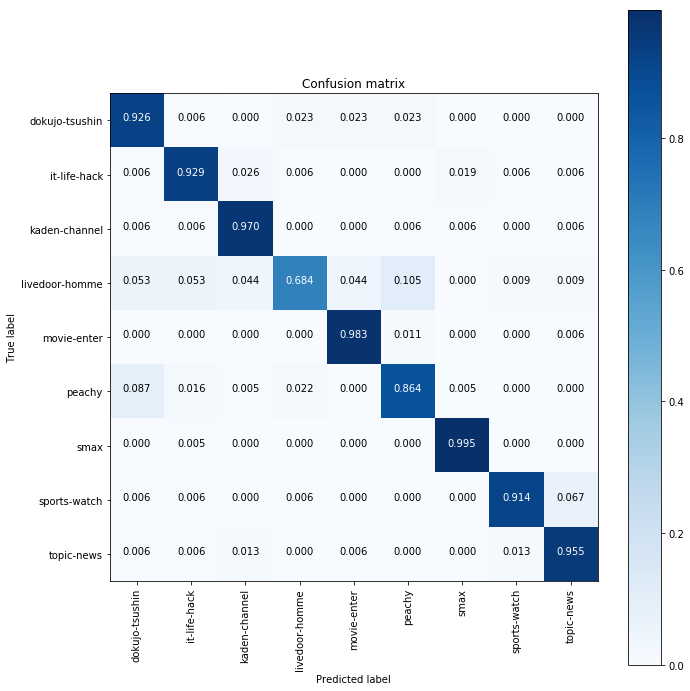

In [38]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)